# Experiments implementing neural networks by hand

In [1]:
import numpy as np
from numpy import typing as npt
from numpy import random as rnd
from collections.abc import Callable, Sequence
from pyclugen import clugen
import matplotlib.pyplot as plt
import time
from PIL import Image
from pathlib import Path
import tensorflow as tf
from mynn import *

2025-12-09 21:27:42.980453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create train and test data with pyclugen

Text(0.5, 0.92, 'Test data')

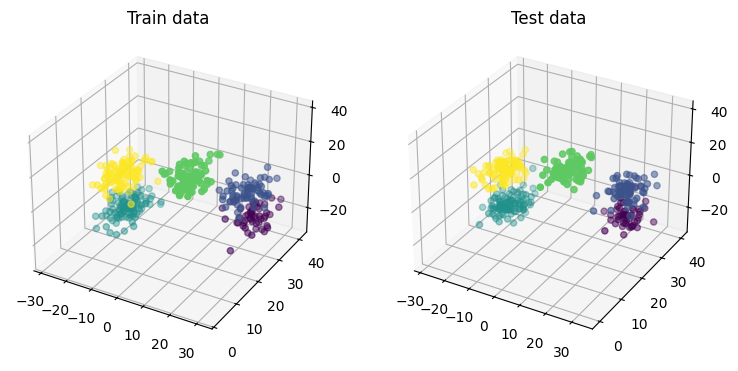

In [2]:
# Clugen parameters
ndims = 3
seed = 123
nclu = 5
npts = 400
direction = [1, 1, 0.5]
angstd = np.pi / 4
csep = [15, 15, 15]
llen = 0.1
llen_std = 0
fat = 3.5

# Generate train data
data_train = clugen(
    ndims,
    nclu,
    npts,
    direction,
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed),
)

# Generate test data, based on parameters from train data
data_test = clugen(
    ndims,
    nclu,
    npts * 2,
    data_train.directions,  # Use final directions in the train data
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed * 9 - 27),
    # Use final values from the train data
    clusizes_fn=data_train.sizes,
    clucenters_fn=data_train.centers,
    llengths_fn=data_train.lengths,
)

# Plot the train and test data
_, axs = plt.subplots(1, 2, figsize=(9, 6), subplot_kw=dict(projection="3d"))
axs[0].scatter(
    data_train.points[:, 0],
    data_train.points[:, 1],
    data_train.points[:, 2],
    c=data_train.clusters,
)
axs[0].set_title("Train data")
axs[1].scatter(
    data_test.points[:, 0],
    data_test.points[:, 1],
    data_test.points[:, 2],
    c=data_test.clusters,
)
axs[1].set_title("Test data")

## Experiments

In [3]:
# Value that output nodes are expected to have when activated or otherwise
# assuming 1-of-n output encoding
node_off = 0.1
node_on = 0.9

# Convert output to appropriate NN format output
clunn_train, _ = categ2oneofn(data_train.clusters, node_off, node_on)
clunn_test, _ = categ2oneofn(data_test.clusters, node_off, node_on)

### Compare myNN with Keras

In [4]:
# Backpropagation parameters
epochs = 100
eta = 0.05
mom = 0.15
topol = [ndims, 6, nclu]

In [5]:
########
# MyNN #
########

# Prepare hooks for registering accuracy
fitreg_mynn = AccuracyRegister(
    data_train.points, clunn_train, epochs, node_off, node_on
)

# Test vectorized backpropagation
mynn = vbackpropagation(
    data_train.points, clunn_train, topol, epochs, eta, mom, hooks=[fitreg_mynn]
)

In [6]:

#########
# Keras #
#########

# Weight initializer
unif_winit = tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=123)

# Using Sequential() to build layers one after another
model = tf.keras.Sequential()

# Add input layer
model.add(tf.keras.layers.Input(shape=(ndims,)))

# Add hidden layers
for l in range(1, len(topol) - 1):
    model.add(tf.keras.layers.Dense(
            units=topol[l],
            activation="sigmoid",
            kernel_initializer=unif_winit,
            bias_initializer=unif_winit,
        ))

# Add output layer
model.add(tf.keras.layers.Dense(
            units=nclu,
            activation="sigmoid",
            kernel_initializer=unif_winit,
            bias_initializer=unif_winit,
        ))

model.compile(
    loss=tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE),
    optimizer=tf.keras.optimizers.SGD(learning_rate=eta, momentum=mom),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.MeanSquaredError()],
)

history = model.fit(
    x=data_train.points,
    y=clunn_train,
    epochs=epochs,
    batch_size=1,
    shuffle=False,
)

I0000 00:00:1765315671.054887   80516 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1035 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


Epoch 1/100
  1/400 ━━━━━━━━━━━━━━━━━━━━ 2:25 365ms/step - categorical_accuracy: 1.0000 - loss: 0.1537 - mean_squared_error: 0.1537

2025-12-09 21:27:51.703284: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ac8ec005b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-09 21:27:51.703297: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-12-09 21:27:51.715130: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-09 21:27:51.740112: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
I0000 00:00:1765315671.871493   80601 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - categorical_accuracy: 0.4825 - loss: 0.0988 - mean_squared_error: 0.0988
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - categorical_accuracy: 0.4950 - loss: 0.0867 - mean_squared_error: 0.0867
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - categorical_accuracy: 0.6175 - loss: 0.0780 - mean_squared_error: 0.0780
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - categorical_accuracy: 0.6650 - loss: 0.0700 - mean_squared_error: 0.0700
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - categorical_accuracy: 0.7475 - loss: 0.0612 - mean_squared_error: 0.0612
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - categorical_accuracy: 0.8225 - loss: 0.0535 - mean_squared_error: 0.0535
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - categorical_accuracy: 0.8575 - loss: 0.0473 - mean_squared_error: 0.0473
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - categorical_accuracy: 0.8650 - loss: 0.0427 -

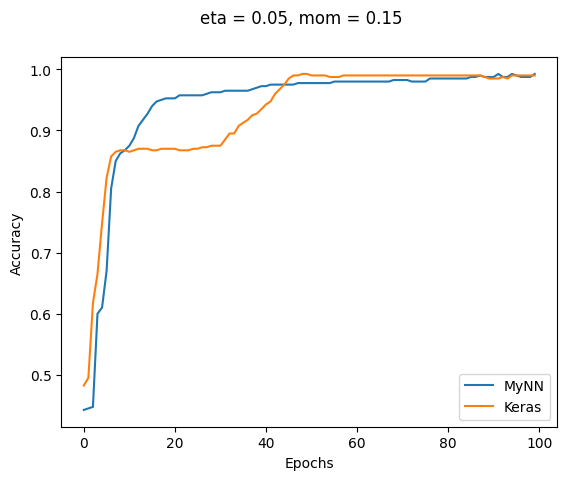

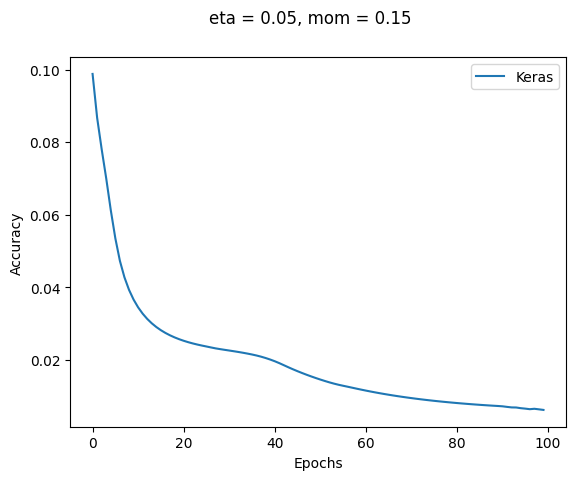

In [7]:
# Plot accuracy
plot_accuracy(
    epochs,
    {
        "MyNN": fitreg_mynn.accuracies,
        "Keras": history.history['categorical_accuracy'],
    },
    f"eta = {eta}, mom = {mom}",
)

plot_accuracy(
    epochs,
    {
        #"MyNN": fitreg_mynn.accuracies,
        "Keras": history.history['mean_squared_error'],
    },
    f"eta = {eta}, mom = {mom}",
)

In [8]:
mynn

[array([[ 0.11943237, -0.04015195, -0.07952373, -0.03109055, -0.0271274 ,
          0.05517558],
        [-0.0630903 , -0.33621178,  0.41240507,  0.36092076, -0.03620722,
         -0.15185496],
        [ 0.34849413,  0.0328472 , -0.03126393,  0.00818301,  0.30938571,
         -0.00890754],
        [ 1.0086397 , -0.06758585, -0.74249963,  0.04815103, -0.30453235,
          0.09864397]]),
 array([[ 0.04157458, -3.0100033 , -1.0661149 ,  0.77695378, -1.05457964],
        [-3.47201209,  3.30291971, -2.17985035,  0.26856498,  1.04610006],
        [-1.50759504, -1.50449166,  1.12382753, -0.57711801,  1.06634945],
        [-0.09261555,  2.14248001,  2.26972279, -1.52650146, -3.23634197],
        [ 1.5670444 , -1.51204699, -2.03758657,  1.01299967, -2.19440816],
        [ 0.07962588,  0.96856728, -1.01706248, -2.53807654,  0.92441084],
        [-0.96780112, -1.89779225,  1.07702068, -0.01688076,  0.24400469]])]

In [9]:
model.weights

[<Variable path=sequential/dense/kernel, shape=(3, 6), dtype=float32, value=[[ 0.47214758 -0.5353201   0.53191984 -0.05943539  0.0517701  -0.5144505 ]
  [ 0.00869394  0.0589346  -0.04909172  0.38680047  0.44791412  0.0949714 ]
  [ 0.0477935   0.9911102  -0.9737023  -0.3578234   0.0633264  -0.98538506]]>,
 <Variable path=sequential/dense/bias, shape=(6,), dtype=float32, value=[-0.00135335  0.07827453 -0.12968469 -0.01896476 -0.01072204 -0.05742805]>,
 <Variable path=sequential/dense_1/kernel, shape=(6, 5), dtype=float32, value=[[ 2.2094579   0.7570739  -3.2537584   0.9508489  -2.0177376 ]
  [-1.1976992  -1.4312285  -2.25561     0.6920781   1.7215668 ]
  [-0.4363845   0.8899767   1.5613912  -1.0384345  -2.2106564 ]
  [-0.3646217   1.2894603  -0.13412803 -2.1555896   0.8877715 ]
  [-1.4428326  -0.5310884  -0.41733527  0.1884293  -0.78857607]
  [ 2.1823921  -3.0625553   1.277837   -0.9188167   1.0623463 ]]>,
 <Variable path=sequential/dense_1/bias, shape=(5,), dtype=float32, value=[-1.5148